<Figure size 1000x600 with 0 Axes>

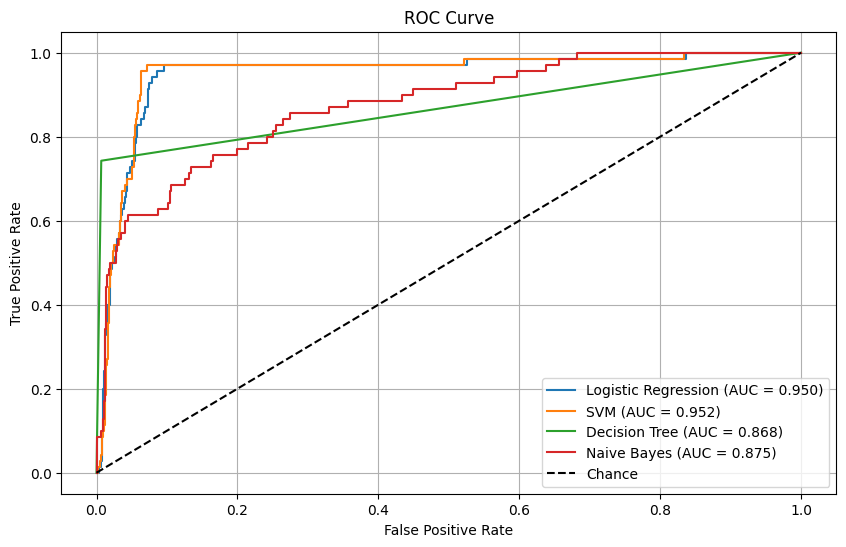

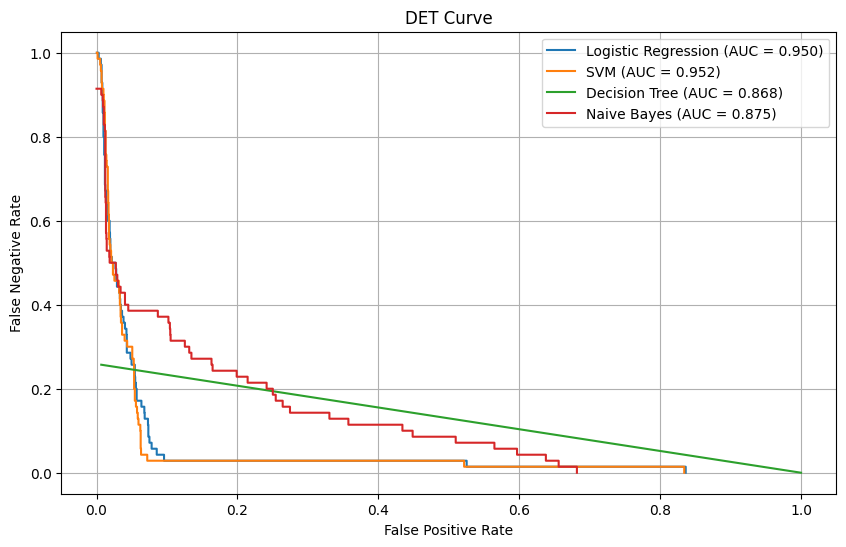

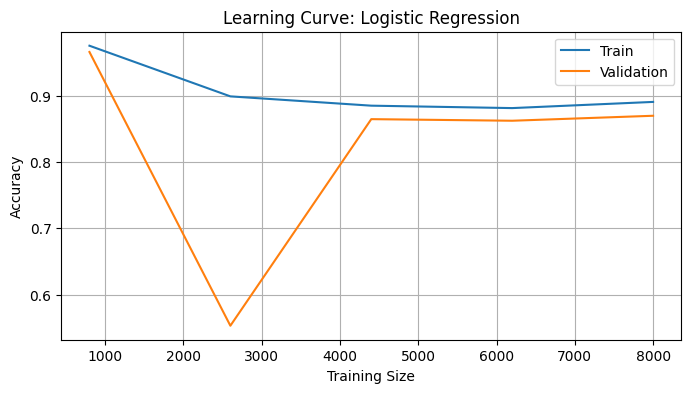

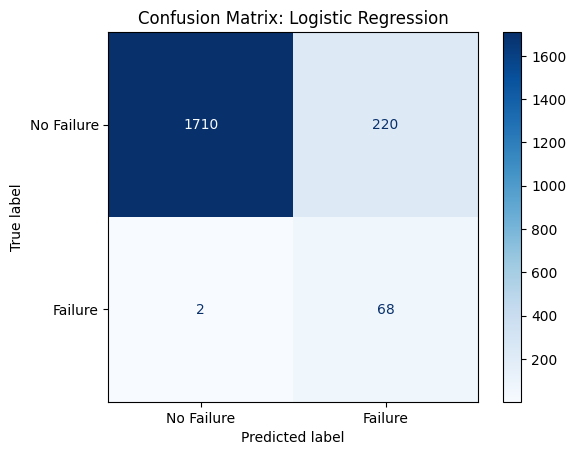

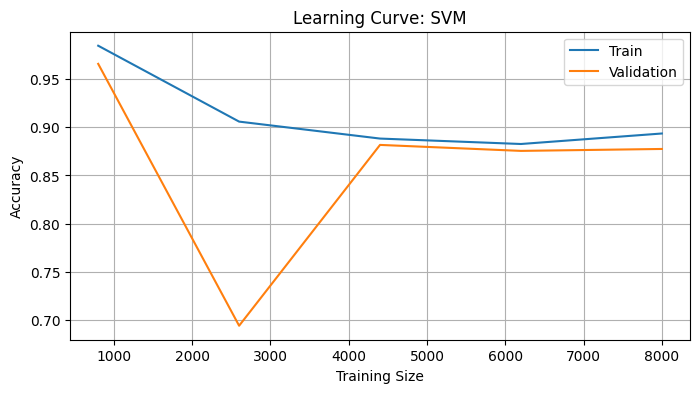

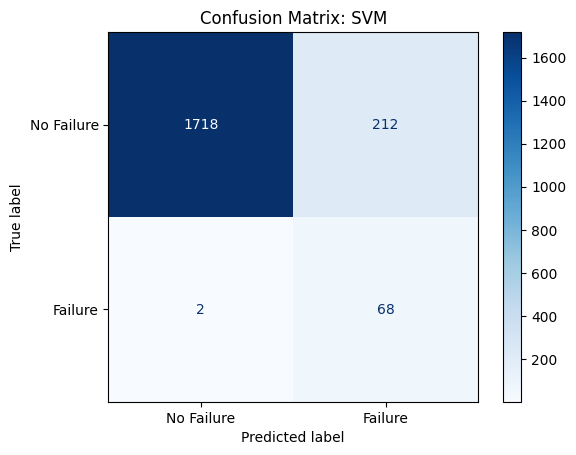

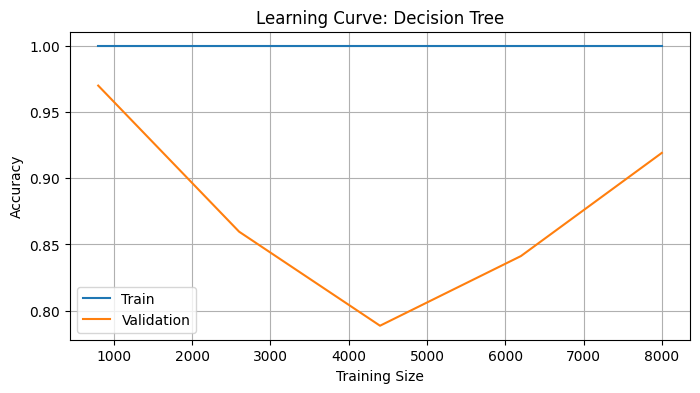

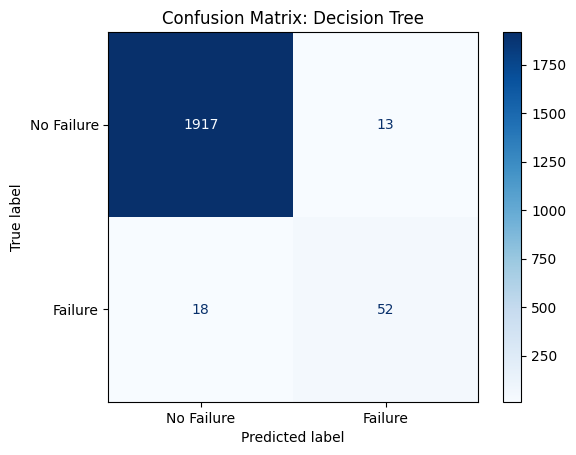

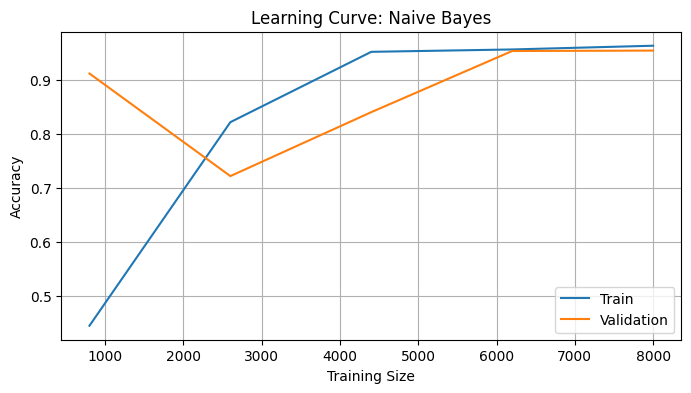

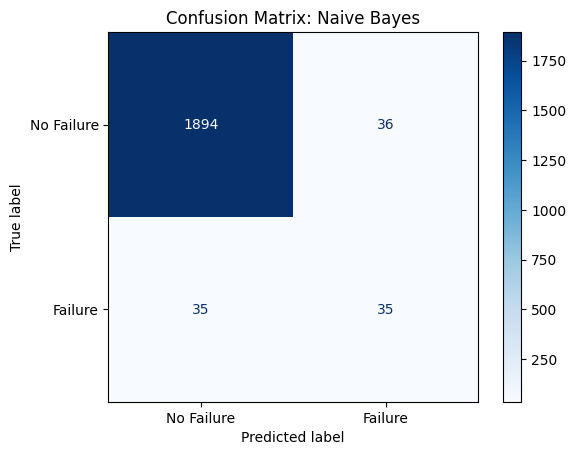


--- Evaluation Summary ---
                     Accuracy  F1 Score  Precision    Recall  Specificity  \
Logistic Regression    0.8890  0.379888   0.236111  0.971429     0.886010   
SVM                    0.8930  0.388571   0.242857  0.971429     0.890155   
Decision Tree          0.9845  0.770370   0.800000  0.742857     0.993264   
Naive Bayes            0.9645  0.496454   0.492958  0.500000     0.981347   

                          AUC  Log Loss       MCC     Kappa  \
Logistic Regression  0.949852  0.333858  0.448831  0.342884   
SVM                  0.951606  0.095618  0.456333  0.352300   
Decision Tree        0.868061  0.558677  0.762922  0.762361   
Naive Bayes          0.874582  0.160684  0.478069  0.478056   

                     Misclassification Error  
Logistic Regression                   0.1110  
SVM                                   0.1070  
Decision Tree                         0.0155  
Naive Bayes                           0.0355  


In [1]:
# --- STEP 1: Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, classification_report, roc_curve, det_curve,
    confusion_matrix, ConfusionMatrixDisplay,  matthews_corrcoef, cohen_kappa_score, log_loss
)


# --- STEP 2: Load and Prepare Data ---
df = pd.read_csv("file1.csv")

df["Failure"] = (df["Diagnostic"] != "No failure").astype(int)
df = df.drop(columns=["UDI", "Date", "Product ID", "Diagnostic"], errors="ignore")

X = df.drop(columns=["Failure"])
y = df["Failure"]

# --- STEP 3: Identify Column Types ---
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# --- STEP 4: Build Preprocessing Pipeline ---
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numerical_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

# --- STEP 5: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- STEP 6: Define Models ---
models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42),
    "SVM": SVC(kernel='linear', class_weight="balanced", probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Naive Bayes": GaussianNB()
}

# --- STEP 7: Train, Predict, Evaluate ---
results = {}

# Plot ROC curves
plt.figure(figsize=(10, 6))
for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else pipeline.decision_function(X_test)

    # Metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    specificity = tn / (tn + fp)
    misclassification_error = (fp + fn) / (tp + tn + fp + fn)
    logloss = log_loss(y_test, y_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)


    results[name] = {
        "model": pipeline,
        "accuracy": acc,
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "auc": auc_score,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "specificity": specificity,
        "log_loss": logloss,
        "mcc": mcc,
        "kappa": kappa,
        "misclassification_error": misclassification_error
    }



    # ROC Curve
plt.figure(figsize=(10, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    auc_score = res["auc"]
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# --- STEP 8: DET Curve ---
plt.figure(figsize=(10, 6))
for name, res in results.items():
    fpr, fnr, _ = det_curve(y_test, res["y_proba"])
    auc_score = res["auc"]
    plt.plot(fpr, fnr, label=f"{name} (AUC = {auc_score:.3f})")

plt.title("DET Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.legend(loc="upper right")
plt.grid()
plt.show()


# --- STEP 9: Learning Curves and Confusion Matrices ---
for name, res in results.items():
    model = res["model"]

    # Learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(8, 4))
    plt.plot(train_sizes, train_scores_mean, label="Train")
    plt.plot(train_sizes, test_scores_mean, label="Validation")
    plt.title(f"Learning Curve: {name}")
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test, res["y_pred"], display_labels=["No Failure", "Failure"], cmap="Blues"
    )
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()

# --- STEP 10: Summary Table ---
summary_df = pd.DataFrame({
    model: {
        "Accuracy": res["accuracy"],
        "F1 Score": res["f1"],
        "Precision": res["precision"],
        "Recall": res["recall"],
        "Specificity": res["specificity"],
        "AUC": res["auc"],
        "Log Loss": res["log_loss"],
        "MCC": res["mcc"],
        "Kappa": res["kappa"],
        "Misclassification Error": res["misclassification_error"]
    }
    for model, res in results.items()
}).T


print("\n--- Evaluation Summary ---")
print(summary_df)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training LSTM...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


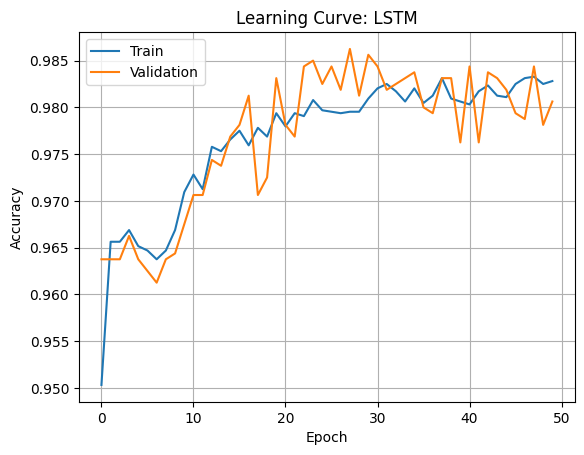

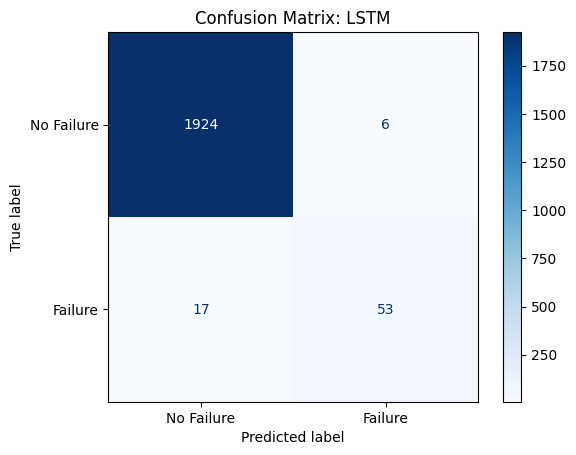


Training 1D CNN...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


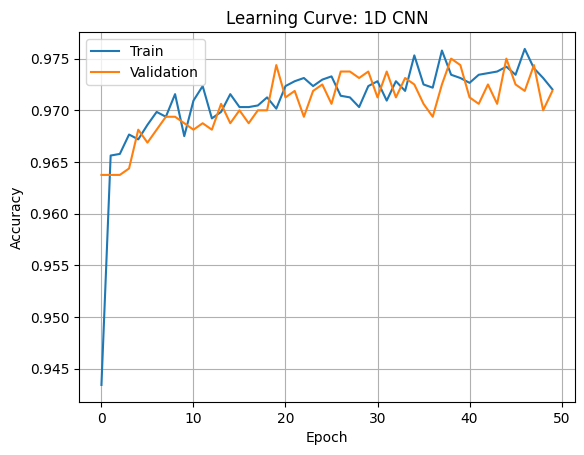

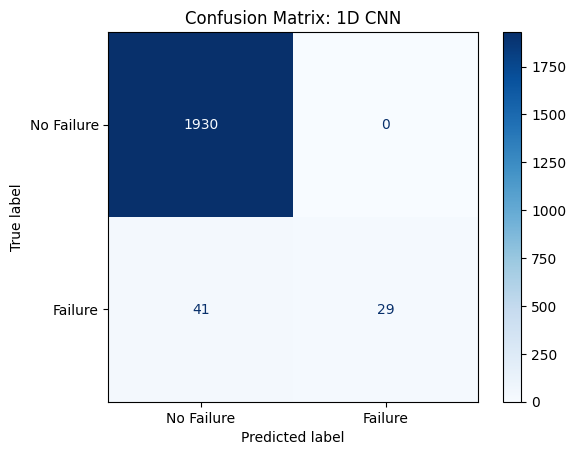


Training Transformer...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


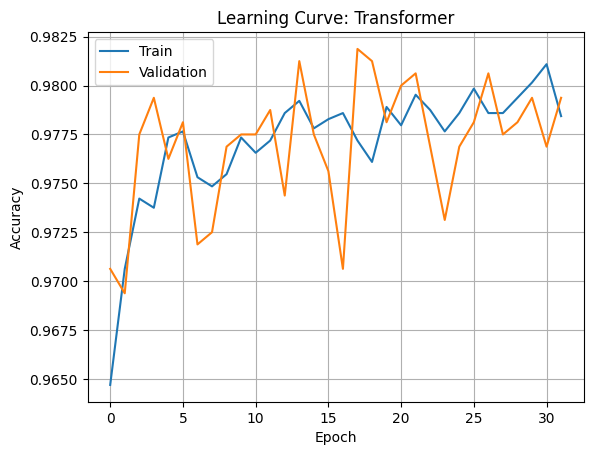

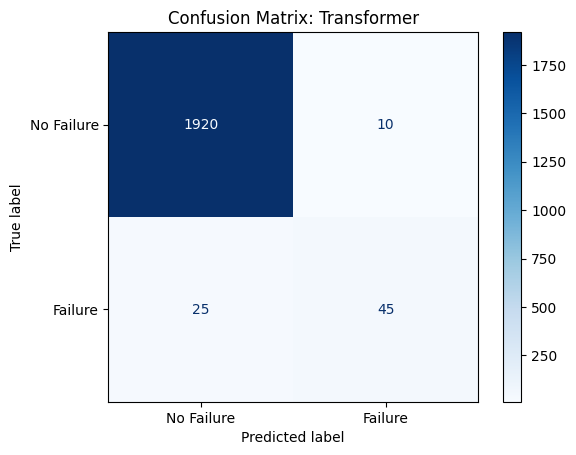

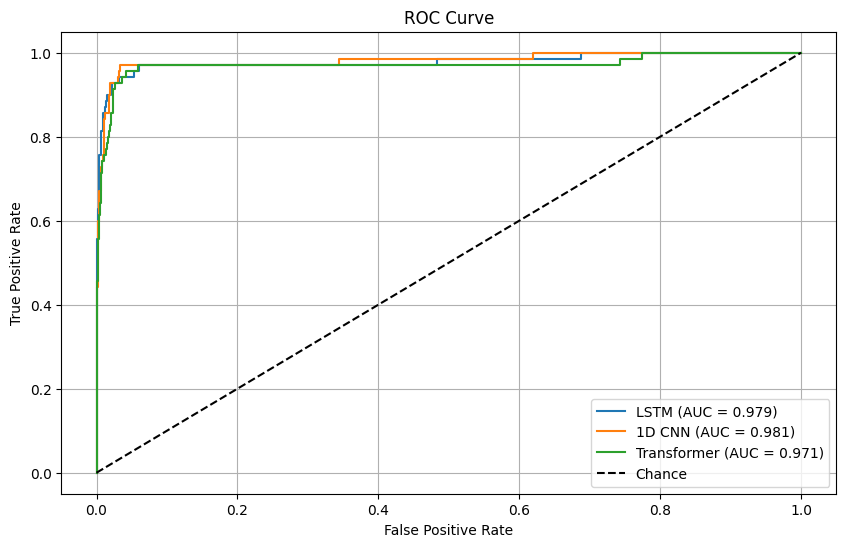

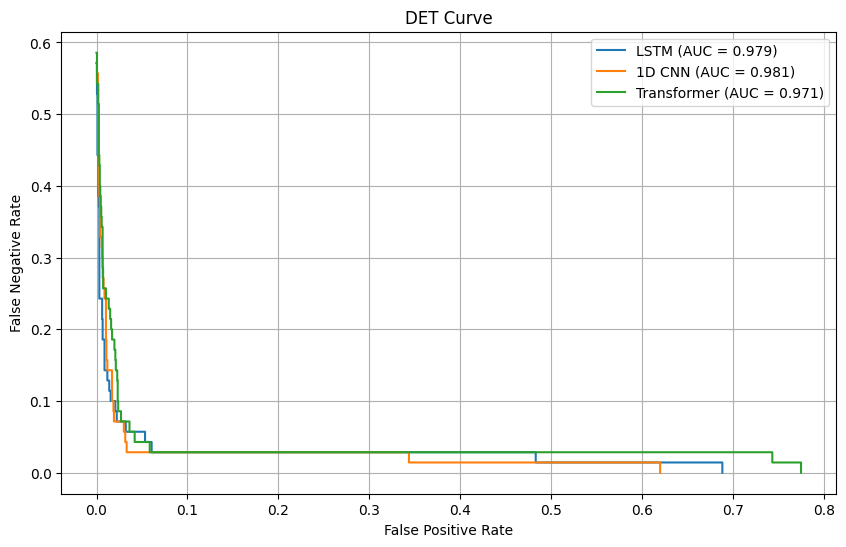


--- Deep Learning Evaluation Summary ---
             Accuracy  F1 Score  Precision    Recall  Specificity       AUC  \
LSTM           0.9885  0.821705   0.898305  0.757143     0.981347  0.978564   
1D CNN         0.9795  0.585859   1.000000  0.414286     0.981347  0.981318   
Transformer    0.9825  0.720000   0.818182  0.642857     0.981347  0.971466   

             Log Loss       MCC     Kappa  Misclassification Error  
LSTM         0.160684  0.478069  0.478056                   0.0355  
1D CNN       0.160684  0.478069  0.478056                   0.0355  
Transformer  0.160684  0.478069  0.478056                   0.0355  


In [2]:
# --- STEP 1: Preprocess (reusing previous split and pipeline) ---
# Apply preprocessor from earlier classical models
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Reshape for sequence models
X_train_seq = X_train_processed.reshape((X_train_processed.shape[0], X_train_processed.shape[1], 1))
X_test_seq = X_test_processed.reshape((X_test_processed.shape[0], X_test_processed.shape[1], 1))
input_shape = X_train_seq.shape[1:]

# --- STEP 2: Import TensorFlow/Keras ---
from tensorflow.keras.layers import Reshape
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Conv1D, MaxPooling1D, Flatten,
    LSTM, Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Reshape, Dense, Dropout,
    MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve, det_curve, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd

# --- STEP 3: Define Models ---
def build_mlp(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(32, input_shape=input_shape),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_cnn(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model



def build_transformer(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Reshape((1, input_dim))(inputs)
    x = Dense(64)(x)
    x = MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)



models = {
    #"MLP": build_mlp(X_train_processed.shape[1]),
    "LSTM": build_lstm(input_shape),
    "1D CNN": build_cnn(input_shape),
    "Transformer": build_transformer(X_train_processed.shape[1])
}

# --- STEP 4: Train and Evaluate ---
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train_processed if name == "MLP" else X_train_seq,
        y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=0,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )

    X_eval = X_test_processed if name == "MLP" else X_test_seq
    y_proba = model.predict(X_eval).ravel()
    y_pred = (y_proba >= 0.5).astype(int)

    results[name] = {
        "model": model,
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_proba),
        "y_pred": y_pred,
        "y_proba": y_proba,
        "history": history,
        "specificity": specificity,
        "log_loss": logloss,
        "mcc": mcc,
        "kappa": kappa,
        "misclassification_error": misclassification_error
    }

    # Plot learning curve
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f"Learning Curve: {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=["No Failure", "Failure"], cmap="Blues"
    )
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()

# --- STEP 5: ROC and DET Curves ---
plt.figure(figsize=(10, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    auc_score = res["auc"]
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# --- DET Curve with AUC in Labels ---
plt.figure(figsize=(10, 6))
for name, res in results.items():
    fpr, fnr, _ = det_curve(y_test, res["y_proba"])
    auc_score = res["auc"]
    plt.plot(fpr, fnr, label=f"{name} (AUC = {auc_score:.3f})")

plt.title("DET Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.legend(loc="upper right")
plt.grid()
plt.show()


# --- STEP 6: Summary Table ---
summary= pd.DataFrame({
    model: {
        "Accuracy": res["accuracy"],
        "F1 Score": res["f1"],
        "Precision": res["precision"],
        "Recall": res["recall"],
        "Specificity": res["specificity"],
        "AUC": res["auc"],
        "Log Loss": res["log_loss"],
        "MCC": res["mcc"],
        "Kappa": res["kappa"],
        "Misclassification Error": res["misclassification_error"]
    }
    for model, res in results.items()
}).T

print("\n--- Deep Learning Evaluation Summary ---")
print(summary)



Training GRU...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


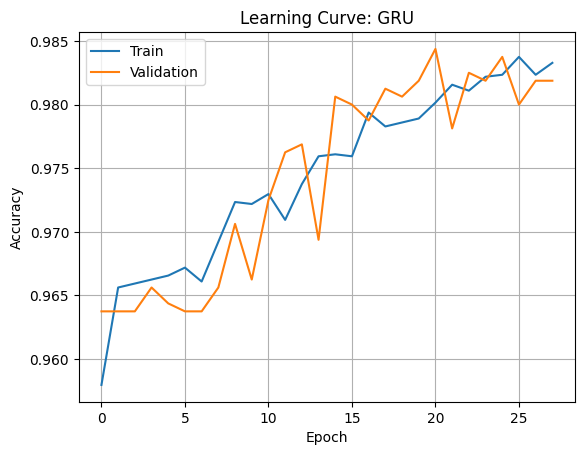

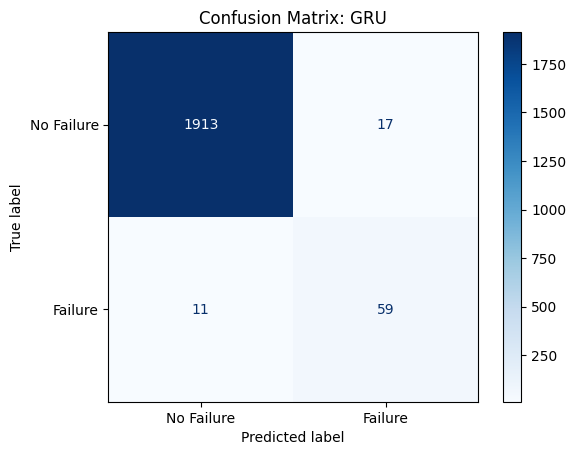


Training Bi-LSTM...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


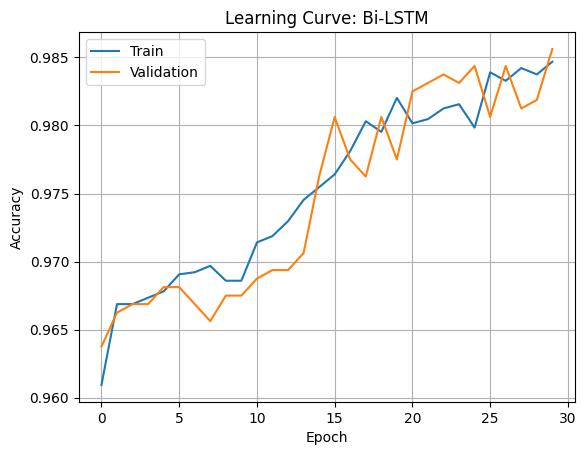

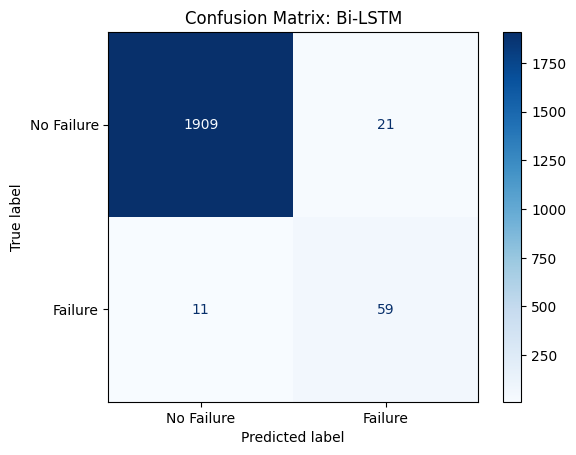

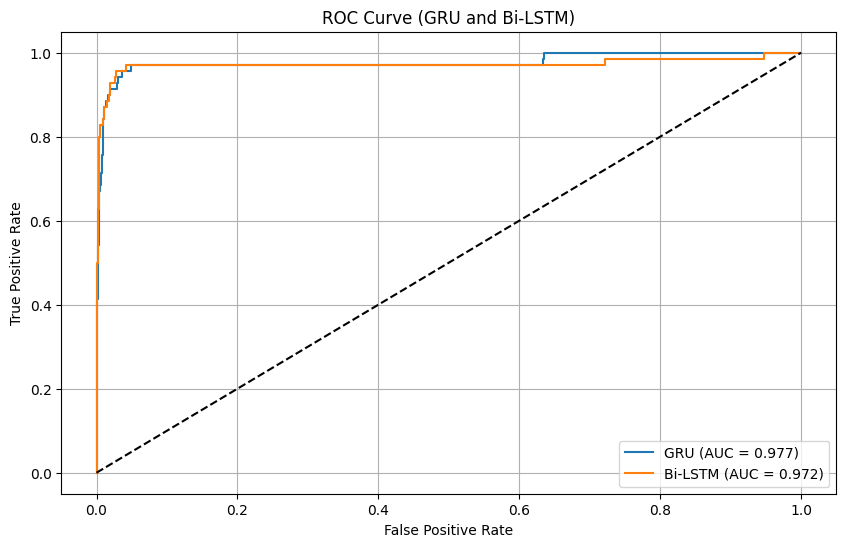

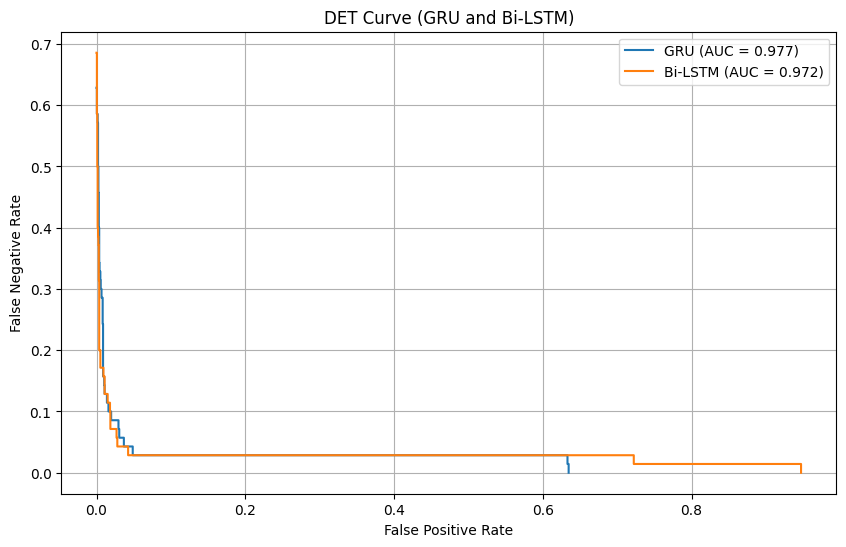


--- Evaluation Summary: GRU and Bi-LSTM ---
         Accuracy  F1 Score  Precision    Recall  Specificity       AUC  \
GRU         0.986  0.808219   0.776316  0.842857     0.981347  0.976684   
Bi-LSTM     0.984  0.786667   0.737500  0.842857     0.981347  0.972206   

         Log Loss       MCC     Kappa  Misclassification Error  
GRU      0.160684  0.478069  0.478056                   0.0355  
Bi-LSTM  0.160684  0.478069  0.478056                   0.0355  


In [3]:
# STEP 1: Import Required Layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    roc_curve, det_curve, ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt
import pandas as pd

# STEP 2: Define Models
def build_gru(input_shape):
    model = Sequential([
        GRU(32, input_shape=input_shape),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(GRU(32), input_shape=input_shape),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

# STEP 3: Create Model Dictionary
input_shape = X_train_seq.shape[1:]
models_combined = {
    "GRU": build_gru(input_shape),
    "Bi-LSTM": build_bilstm(input_shape)
}

# STEP 4: Train and Evaluate
results_combined = {}

for name, model in models_combined.items():
    print(f"\nTraining {name}...")

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train_seq,
        y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.2,
        verbose=0,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
    )

    y_proba = model.predict(X_test_seq).ravel()
    y_pred = (y_proba >= 0.5).astype(int)

    results_combined[name] = {
        "model": model,
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_proba),
        "y_pred": y_pred,
        "y_proba": y_proba,
        "history": history,
        "specificity": specificity,
        "log_loss": logloss,
        "mcc": mcc,
        "kappa": kappa,
        "misclassification_error": misclassification_error
    }

    # Learning Curve
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f"Learning Curve: {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=["No Failure", "Failure"], cmap="Blues"
    )
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()

# STEP 5: ROC and DET Curves
plt.figure(figsize=(10, 6))
for name, res in results_combined.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    auc_score = res["auc"]
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (GRU and Bi-LSTM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
for name, res in results_combined.items():
    fpr, fnr, _ = det_curve(y_test, res["y_proba"])
    auc_score = res["auc"]
    plt.plot(fpr, fnr, label=f"{name} (AUC = {auc_score:.3f})")
plt.title("DET Curve (GRU and Bi-LSTM)")
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.legend()
plt.grid()
plt.show()

# STEP 6: Summary Table
summary_combined = pd.DataFrame({
    model: {
        "Accuracy": res["accuracy"],
        "F1 Score": res["f1"],
        "Precision": res["precision"],
        "Recall": res["recall"],
        "Specificity": res["specificity"],
        "AUC": res["auc"],
        "Log Loss": res["log_loss"],
        "MCC": res["mcc"],
        "Kappa": res["kappa"],
        "Misclassification Error": res["misclassification_error"]
    }
    for model, res in results_combined.items()
}).T


print("\n--- Evaluation Summary: GRU and Bi-LSTM ---")
print(summary_combined)


 Accuracy: 0.889

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94      1930
           1       0.24      0.97      0.38        70

    accuracy                           0.89      2000
   macro avg       0.62      0.93      0.66      2000
weighted avg       0.97      0.89      0.92      2000



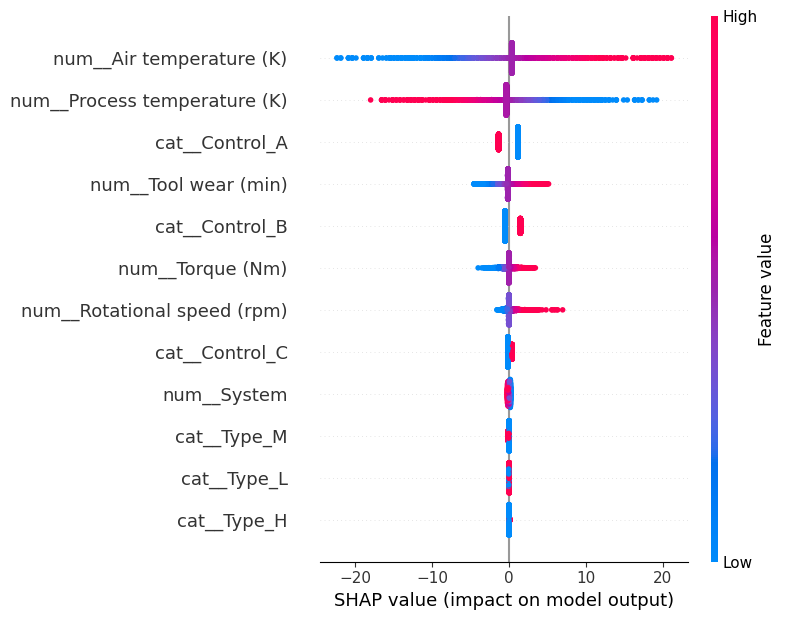

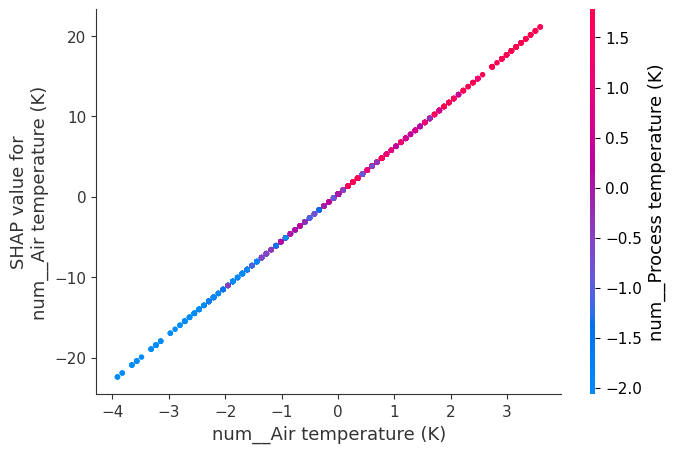

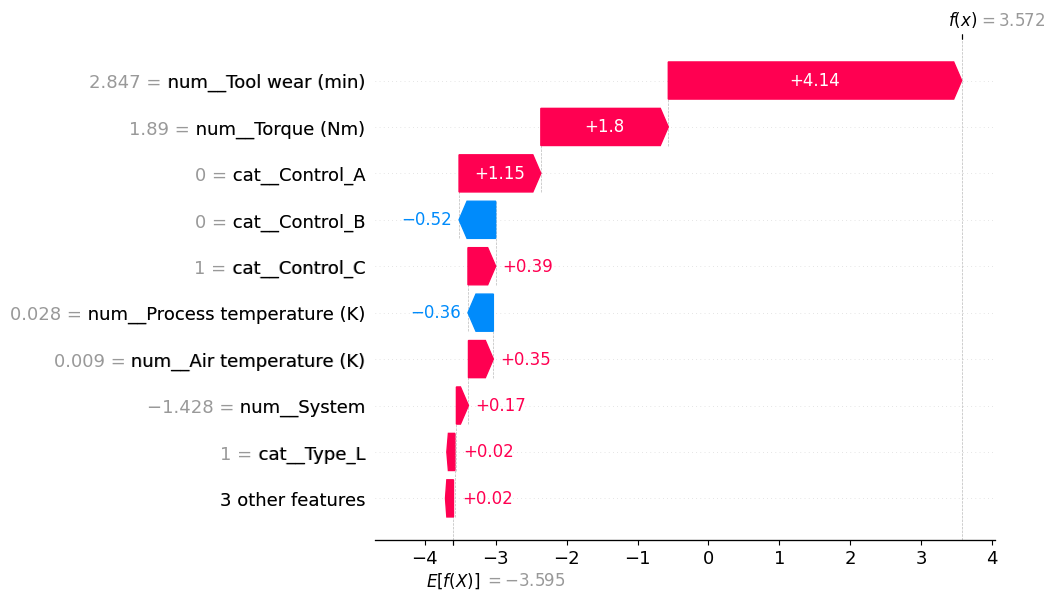

In [4]:
#  SHAP EXPLAINABILITY (CLASSICAL MODEL)


# STEP 1: Install SHAP (only needs to run once)
#!pip install shap --quiet

# STEP 2: Imports
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# STEP 3: Train a classical model (Logistic Regression)
clf = LogisticRegression(class_weight="balanced", max_iter=1000)
clf.fit(X_train_processed, y_train)

y_pred = clf.predict(X_test_processed)


# Predict and evaluate
y_pred = clf.predict(X_test_processed)
print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# STEP 4: Run SHAP
explainer = shap.Explainer(clf, X_train_processed)
shap_values = explainer(X_test_processed)


# STEP 5: Global Feature Importance
shap.summary_plot(
    shap_values,
    X_test_processed,
    feature_names=preprocessor.get_feature_names_out(),
    show=True
)

# STEP 6: Force Plot (Local Explanation)
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0].values,
    X_test_processed[0],
    feature_names=preprocessor.get_feature_names_out()
)

feature_names = preprocessor.get_feature_names_out()
shap.dependence_plot("num__Air temperature (K)", shap_values.values, X_test_processed, feature_names=feature_names)


def plot_waterfall(shap_values, X_transformed, index, feature_names):
    explanation = shap.Explanation(
        values=shap_values[index].values,
        base_values=shap_values[index].base_values,
        data=X_transformed[index],
        feature_names=feature_names
    )
    shap.plots.waterfall(explanation)

plot_waterfall(shap_values, X_test_processed, 0, feature_names)


